# Temporal-Difference Learning

In this notebook, we will learn Temporal-Difference (TD) Methods using CliffWalking environment from OpenAI Gym. You can find more about this environment [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py).

## Table of Contents

- [CliffWalking Env](#cw_env)
- [Sarsa: On-policy TD Control](#sarsa)
- [Q-learning: Off-policy TD Control](#q_learning)
- [References](#references)
- [Further Resources](#resources)

<a id=cw_env></a>
## CliffWalking Env

Lets explore gym CliffWalking environment. We begin by importing the necessary modules and packages.

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

We can create an instance of the CliffWalking env by calling `gym.make('CliffWalking-v0')`.

In [3]:
env = gym.make('CliffWalking-v0')

Now, lets find the details information of observation and action spaces.

In [3]:
env.observation_space

Discrete(48)

In [4]:
env.action_space

Discrete(4)

CliffWalking environment is adapted from example (6.6) of Sutton and Barto text book.

Observation space (State) is 4x12 matrix, with (using NumPy matrix indexing):

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```

- [3, 0] as the start at bottom-left (state `36`)
- [3, 11] as the goal at bottom-right (state `47`)
- [3, 1..10] as the cliff at bottom-center (states `37 to 46`)

Action space consists of four discrete values.

- 0 = `UP`
- 1 = `RIGHT`
- 2 = `DOWN`
- 3 = `LEFT`

This CliffWalking environment information is documented in the [source code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py#L30) as follows:

> Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward and a reset to the start. An episode terminates when the agent reaches the goal.

Optimal policy of the environment is shown below.

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [ >,  >,  >,  >,  >,  >,  >,  >,  >,  >,  >,  >],
 [ S, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,  G]]
```

Run the code cell below to know more about the CliffWalking environment.

In [5]:
# initialize the env
state = env.reset()

while True:
    
    for i in range(2):
        action = env.action_space.sample()
        print(f"Current state {i}: ",state)
        print(f"Current action {i}: ",action)
        state, reward, done, info = env.step(action)
        print(f"Reward {i+1}: ",reward)
        env.render()
    
    break

Current state 0:  36
Current action 0:  2
Reward 1:  -1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Current state 1:  36
Current action 1:  3
Reward 2:  -1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



<a id=sarsa></a>
## Sarsa: On-policy TD Control

Lets start learning TD methods by implementing **Sarsa(0)**, which is an on-policy TD Control method. The pseudocode below is used to implement the algorithm.

![](imgs/sarsa0.jpeg)

We will call this function `sarsa`.

The function accepts five input arguments:

- `env`: an instance of OpenAI Gym's CliffWalking environment
- `num_of_episodes`: number of episodes to play
- `alpha`: step-size parameter in update equation
- `plot_every`: store average scores over n episodes
- `gamma`: discount rate (default = 1.0)

The function returns two outputs:

- `Q`: Q-Table of state, action pairs $Q(s,a)$
- `avg_scores`: average scores for visualizing

In [4]:
def epsilon_greedy_action(epsilon, number_of_actions, Q):
    
    policy = np.ones(number_of_actions) * epsilon / number_of_actions
    max_action_index = np.argmax(Q)
    policy[max_action_index] = 1 - epsilon + (epsilon / number_of_actions)
    action = np.random.choice(np.arange(number_of_actions), p=policy)
    
    return action

In [29]:
def sarsa(env, num_of_episodes, alpha, plot_every=100, gamma=1.0):
    
    # initialize empty dictionary Q
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_of_episodes)
    
    for i in range(1, num_of_episodes+1):
        
        score = 0
        
        # initialize the episode
        s = env.reset()
        
        # calculate epsilon value
        epsilon = 1 / i
        
        # epsilon-greedy policy action selection
        a = epsilon_greedy_action(epsilon, env.action_space.n, Q[s])
        
        # run until episode terminates
        while True:
            
            ##############################
            # take action A, observe R,S'
            ##############################
            next_s, reward, done, info = env.step(a)
            score += reward
            
            ################################################
            # choose A' from S' using epsilon-greedy policy
            ################################################
            next_a = epsilon_greedy_action(epsilon, env.action_space.n, Q[next_s])
            
            #######################################################
            # Q(s,a) <- Q(s,a) + alpha*[R+gamma*Q(s',a') - Q(s,a)]
            #######################################################
            td_target = reward + gamma*Q[next_s][next_a]
            Q[s][a] = Q[s][a] + alpha*(td_target - Q[s][a])
            
            ###################
            # s <- s'; a <- a'
            ###################
            s = next_s
            a = next_a
            
            if done:
                tmp_scores.append(score)
                break
                
        if (i % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            if (i % 1000 == 0):
                print(f"Episode {i}/{num_of_episodes}: Average Reward: {np.max(avg_scores)}")

    return Q, avg_scores

Run the code cell below to train the agent. Feel free to tune the hyperparameters to get the optimal action-value function.

Episode 1000/5000: Average Reward: -33.46
Episode 2000/5000: Average Reward: -20.24
Episode 3000/5000: Average Reward: -17.05
Episode 4000/5000: Average Reward: -15.58
Episode 5000/5000: Average Reward: -13.0


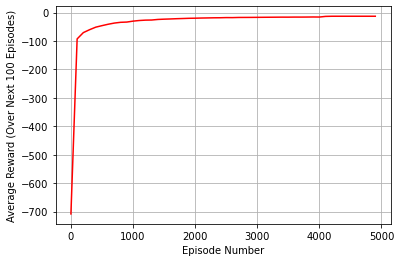

In [59]:
env.seed(0)
np.random.seed(0)

# Hyperparameters
num_of_episodes = 5000
alpha = 0.012
plot_every = 100
gamma = 1.0

Q, avg_scores = sarsa(env, num_of_episodes, alpha, 
                      plot_every, gamma)

# plot performance
plt.plot(np.linspace(0,num_of_episodes,len(avg_scores),endpoint=False), 
         np.asarray(avg_scores), 'r')

plt.xlabel('Episode Number')
plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
plt.grid(True)
plt.show()

We can plot the corressponding action-value function by running code cell below.

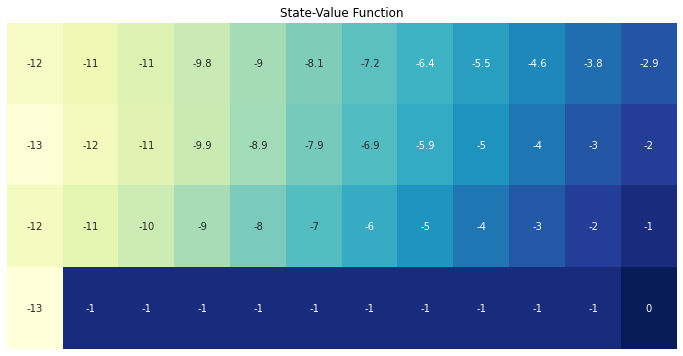

In [64]:
# obtain the corresponding state-value function
V = np.array([np.max(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape(4, 12)

fig = plt.figure(figsize=(12,6))

plt.title('State-Value Function')
sns.heatmap(V, cmap="YlGnBu", cbar=False, annot=True, xticklabels=[], yticklabels=[])
plt.show()

In [10]:
# print the estimated optimal policy
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  0  1  2  1  1  2  1  2  1  2]
 [ 3  1  1  1  1  1  1  2  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


<a id=q_learning></a>
## Q-learning: Off-policy TD Control

We will move to the Sarsamax algorithm, also known as Q-Learning, which is an off-policy TD Control algorithm. In this case, the learned action-value function $Q$ directly estimates $q_*$, the optimal action-value function, independent of the policy being followed.

We will use the pseudocode below to implement our Q-Learning algorithm.

![](imgs/qlearning.jpeg)

We will call this function `qlearning`.

The function accepts five input arguments:

- `env`: an instance of OpenAI Gym's CliffWalking environment
- `num_of_episodes`: number of episodes to play
- `alpha`: step-size parameter in update equation
- `plot_every`: store average scores over n episodes
- `gamma`: discount rate (default = 1.0)

The function returns two outputs:

- `Q`: Q-Table of state, action pairs $Q(s,a)$
- `avg_scores`: average scores for visualizing

In [5]:
def qlearning(env, num_of_episodes, alpha, plot_every=100, gamma=1.0):
    
    # initialize empty dictionary Q
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_of_episodes)
    
    for i in range(1, num_of_episodes+1):
        
        score = 0
        
        # initialize the episode
        s = env.reset()
        
        # calculate epsilon value
        epsilon = 1 / i
        
        # run until episode terminates
        while True:
            
            ##############################################
            # choose A from S using epsilon-greedy policy
            ##############################################
            a = epsilon_greedy_action(epsilon, env.action_space.n, Q[s])
            
            ##############################
            # take action A, observe R,S'
            ##############################
            next_s, reward, done, info = env.step(a)
            score += reward
            
            #######################################################
            # Q(s,a) <- Q(s,a) + alpha*[R+gamma*max_aQ(s',a) - Q(s,a)]
            #######################################################
            td_target = reward + gamma*np.max(Q[next_s])
            Q[s][a] = Q[s][a] + alpha*(td_target - Q[s][a])
            
            ##########
            # s <- s'
            ##########
            s = next_s
            
            if done:
                tmp_scores.append(score)
                break
                
        if (i % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            if (i % 1000 == 0):
                print(f"Episode {i}/{num_of_episodes}: Average Reward: {np.max(avg_scores)}")

    return Q, avg_scores

Episode 1000/5000: Average Reward: -32.57
Episode 2000/5000: Average Reward: -18.92
Episode 3000/5000: Average Reward: -13.29
Episode 4000/5000: Average Reward: -13.0
Episode 5000/5000: Average Reward: -13.0


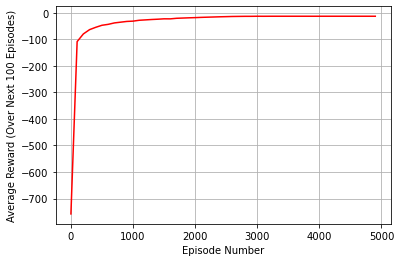

In [6]:
env.seed(0)
np.random.seed(0)

# Hyperparameters
num_of_episodes = 5000
alpha = 0.012
plot_every = 100
gamma = 1.0

Q, avg_scores = qlearning(env, num_of_episodes, alpha, 
                      plot_every, gamma)

# plot performance
plt.plot(np.linspace(0,num_of_episodes,len(avg_scores),endpoint=False), 
         np.asarray(avg_scores), 'r')

plt.xlabel('Episode Number')
plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
plt.grid(True)
plt.show()

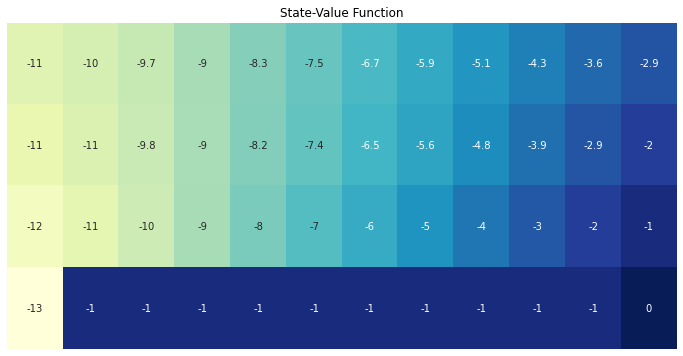

In [7]:
# obtain the corresponding state-value function
V = np.array([np.max(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape(4, 12)

fig = plt.figure(figsize=(12,6))

plt.title('State-Value Function')
sns.heatmap(V, cmap="YlGnBu", cbar=False, annot=True, xticklabels=[], yticklabels=[])
plt.show()

In [9]:
# print the estimated optimal policy
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  0  1  2  1  1  2  1  2  1  2]
 [ 3  1  1  1  1  1  1  2  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


<a id=references></a>
## References

- [Sutton and Barto Textbook (Reinforcement Learning: An Introduction)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)
- [David Silver's Lecture (DeepMind)](https://www.youtube.com/playlist?list=PLqYmG7hTraZBiG_XpjnPrSNw-1XQaM_gB)
- [Udacity's DeepRL Github Repo](https://github.com/udacity/deep-reinforcement-learning)

<a id=resources></a>
## Further Resources

- [Implementation of RL algorithms Github Repo](https://github.com/dennybritz/reinforcement-learning)